# Simple FMI open data API example

This is a simple code example that uses the FMI API ot retrieve temperature observations for the last 20 hours at the Kumpula station and prints them out.

The three libraries we need are `datetime`, which makes handling timestamps and intervals easier. The `datetime` objects represent instants in time and the `timedelta` objects represent intervals in time.

In [1]:
%matplotlib inline

from datetime import datetime, timedelta
from urllib import request
import xml.etree.ElementTree as ET

We store our personal API key in a separate text file so that we don't have to make it publicly available with the code. Reading it from the file into a string is simple.

In [2]:
API_key = open("FMI-KEY.txt","r").read().strip()

## Helper functions

We start by defining to helper functions. It's generally good style to separate small tasks like this into functions.

Here we define a function, which takes a `datetime` object and returns a timestamp as a string, in the format which is required by the API call.

In [11]:
def get_timestring(T):
    """ISO time string without decimals, end in Z, from datetime object."""
    return T.strftime("%Y-%m-%dT%H:%M:%SZ")

Here we define a function which takes a dictionary (which we'll define below) of the query parameters and formats them into a string in the correct way for the query URL.

In [12]:
def get_paramstring(params):
    """Generate a query parameter string from dictionary."""
    kvpairs = ["&{}={}".format(*item) for item in params.items()]
    return "".join(kvpairs)

## Generating the query URL

First we define a template for the URL which we want to retrieve from the open data server. We will fill out the `KEY`, `ID` and `PARAMS` values later.

In [5]:
QueryURLTemplate = "http://data.fmi.fi/fmi-apikey/{KEY}/wfs?request=getFeature&storedquery_id={ID}{PARAMS}"

Then we define all the parameters of the query. Here we want the end point to be now and the starting point to be 20 hours in the past. The site ID 101004 is the Kumpula station. We'll get observations every 10 minutes, and we're interested only in the temperature.

In [13]:
QueryID = "fmi::observations::weather::timevaluepair"

Now = datetime.utcnow()
Start = Now - timedelta(hours=20)
End = Now - timedelta(minutes=0)

QueryParams = {
    "fmisid" : 101004,
    "starttime" : get_timestring(Start),
    "endtime" : get_timestring(End),
    "timestep" : 10,
    "parameters" : "temperature"
}

We create the parameter string from the `QueryParams` dictionary. Then create the query URL from the template.

In [14]:
parStr = get_paramstring(QueryParams)
QueryURL = QueryURLTemplate.format(KEY=API_key, ID=QueryID, PARAMS=parStr)

## Retrieving and processing the data

Make a HTTP request for the URL, which should retrieve an XML document with the desired data. Use `ElementTree` to parse the XML document into a structure of Python lists.

In [15]:
XMLdata = request.urlopen(QueryURL).read()
XMLTree = ET.fromstring(XMLdata)

Retrieve the desired list of elements from the XML tree. There are more robust ways of doing this, based on the name of the element, but this works for now.

Then each of the elements in the list are looped over and the desired data ertrieved from the elements and printed.

In [16]:
# Some magic to get relevant XML elements (knowing the tree structure):
Measurements = [point[0] for point in XMLTree[0][0][6][0]]

Times = []
Temperatures = []

for measurement in Measurements:
    timestr = measurement[0].text
    timestamp = datetime.strptime(timestr, "%Y-%m-%dT%H:%M:%SZ")
    temp = float(measurement[1].text)
    Times.append(timestamp)
    Temperatures.append(temp)

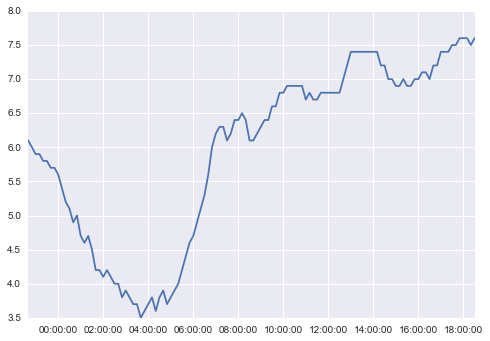

In [17]:
import seaborn as sns

sns.plt.plot(Times, Temperatures)